# Table of Contents
1  Image概述
2  Image operator(mask, clip, select, addBands, export)
3  ImageCollection概述
4  ImageCollection operator(filter, select, set/get, calculation, toList)
5  Example 1. Calculate NDVI for Jiangxi and Extract NDWI for poyang Lake between 1982 to 2021;
6  Example 2. Download huge ImageCollection from google earth engine; -> Download Images
7  Example 3. Extract NDVI values of climate stations from 1982 to 2021; -> Spatial analysis
8  Example 4. Supervised Classification -> Images Classification
9  Example 5. Unsupervised Classification (clustering) 

In [4]:
import ee, os
import geemap
# ee.Initialize()
# Map = geemap.Map()
# Map = geemap.Map(center=(39, 110), zoom=4)
# Map

In [5]:
# -------------------------------------------------------
# 2  ImageCollection 去云
#  Calculate NDVI for Jiangxi
# -------------------------------------------------------
year = 2015, 2015
doy = '-01-01', '-12-31'

start_date = str(year[0]) + doy[0]
end_date = str(year[1]) + doy[1]

jx_bound = ee.FeatureCollection('users/yehuigeo/jx_bound')


In [6]:
def cloudMaskL457(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBand = image.select('ST_B6').multiply(0.00341802).add(149.0)

    return image.addBands(opticalBands, None, True)\
                 .addBands(thermalBand, None, True)\
                 .updateMask(qaMask).updateMask(saturationMask)\
                 .copyProperties(image, ["system:time_start",'system:id'])

def maskS2clouds(image):   # This function was used to mask the clouds for sentinel-2
    qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(
             qa.bitwiseAnd(cirrusBitMask).eq(0))

  # Return the masked and scaled data, without the QA bands.
    return image.updateMask(mask).divide(10000).select("B.*").copyProperties(image, ["system:time_start",'system:id'])

def maskL8sr(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111',2)).eq(0);
    saturationMask = image.select('QA_RADSAT').eq(0);

#   // Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2);
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0);
    
    return image.addBands(opticalBands, None, True)\
                 .addBands(thermalBands, None, True)\
                 .updateMask(qaMask)\
                 .updateMask(saturationMask)\
                 .copyProperties(image, ["system:time_start",'system:id'])

In [7]:
# Landsat 3 MSS Collection 1 Tier 1 Raw Scenes
# Dataset Availability
# 1978-03-05 - 1983-03-31
# Landsat 5+7 scenes
# Dataset Availability
# 1984 - 2012
# get landsat 5
collection5 = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
    .filterBounds(jx_bound) \
    .filterDate(start_date, end_date) \
    .map(cloudMaskL457) \
    .select(['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7'])
# print('Landsat5')
print(collection5.size().getInfo())
# Landsat 7 Collection 1 Tier 1 Raw Scenes
# Dataset Availability
# 1999 - 2021
# get landsat 7
# https://developers.google.com/earth-engine/datasets/catalog/landsat
# https://www.usgs.gov/landsat-missions/landsat-collection-2
collection7 = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
    .filterBounds(jx_bound) \
    .filterDate(start_date, end_date) \
    .map(cloudMaskL457) \
    .select(['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7'])

print(collection7.size().getInfo())

0
247


In [8]:
# 将system:index数据转为list
col7_pix = collection7.aggregate_array('system:index').getInfo()
print(col7_pix[0])

LE07_119040_20150207


In [45]:
# 将两个不同属性的传感器数据合并到一起
col57 = ee.ImageCollection(collection5.merge(collection7))
# col57_pix = col57.aggregate_array('system:index').getInfo()

In [46]:
col57_pix = col57.aggregate_array('system:index').getInfo()

In [156]:
col57_pix[0]

'1_LT05_119040_19860607'

In [157]:
def glst1(pix):
    tp = pix.split('_')[0]
    pr = pix.split('_')[1]
    yr = pix.split('_')[-1][:4]
    mn = pix.split('_')[-1][4:6]
    dy = pix.split('_')[-1][-2::] 
    return list([tp,pr,yr,mn,dy])
# 通过数据id属性来split获取时间等信息
def glst2(pix):
    tp = pix.split('_')[1]
    pr = pix.split('_')[2]
    yr = pix.split('_')[-1][:4]
    mn = pix.split('_')[-1][4:6]
    dy = pix.split('_')[-1][-2::] 
    return list([tp,pr,yr,mn,dy])

In [158]:
col57_pix_lst = list(map(glst2, col57_pix))

In [159]:
import pandas as pd
ln = ['source','path_row','year','month','day']
df57 = pd.DataFrame(col57_pix_lst, columns = ln)
# 输出数据的前10行
df57.head(10)

,source,path_row,year,month,day
0,LT05,119040,1986,06,07
1,LT05,119040,1986,10,29
2,LT05,119040,1986,11,14
3,LT05,119040,1988,11,19
4,LT05,119040,1988,12,05
5,LT05,119040,1989,04,28
6,LT05,119040,1989,05,14
7,LT05,119040,1989,05,30
8,LT05,119040,1989,06,15
9,LT05,119040,1989,07,17


In [161]:
df_mn = df57.groupby(['year','month']).size().reset_index(name='counts')
# df_mn = df.groupby(['year','month']).agg(images=('day','count')).reset_index()
df_mn[['year','month']] = df_gp[['year','month']].apply(pd.to_numeric)
# df_mn['year'] = pd.to_numeric(df_mn.year, errors='coerce')
# df_gp.dtypes
df_mn.head(10)
# -------------------------------


,year,month,counts
0,1985,8,1
1,1986,4,2
2,1986,6,13
3,1986,7,6
4,1986,8,11
5,1986,10,4
6,1986,11,15
7,1986,12,18
8,1987,1,21
9,1987,2,9


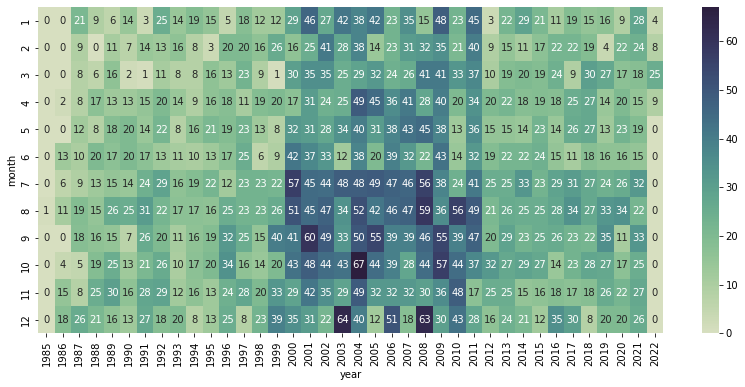

In [154]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# df_pixs = df_gp[['month','year','count']]
df_pixs = df_mn.pivot('month','year','counts')
# 将无数据的位置的值设为0
df_pixs = df_pixs.fillna(0)

plt.figure(figsize=(14,6))
ax = sns.heatmap(df_pixs, annot=True)
# clmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
# ax = sns.heatmap(df_pixs, annot=True, cmap=clmap)


In [162]:
df_id = df57.groupby(['year','path_row']).size().reset_index(name='counts')
df_id[['year','path_row']] = df_id[['year','path_row']].apply(pd.to_numeric)
df_id.head(10)

,year,path_row,counts
0,1985,120039,1
1,1986,119040,3
2,1986,119041,2
3,1986,120039,5
4,1986,120040,5
5,1986,120041,6
6,1986,120042,4
7,1986,121039,6
8,1986,121040,4
9,1986,121041,4


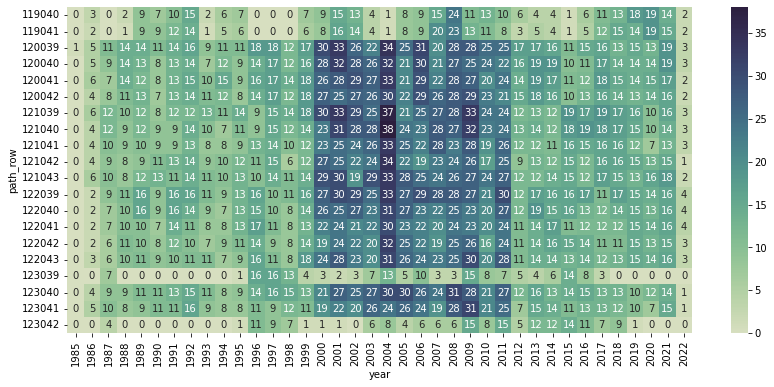

In [165]:
df_px = df_id.pivot('path_row','year','counts')
df_px = df_px.fillna(0)

plt.figure(figsize=(14,6))
clmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
ax = sns.heatmap(df_px, annot=True, cmap=clmap)